In [2]:
# Importing useful packages.
import numpy as np
import pandas as pd
import os
import bz2
import json
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse
from random import randrange
from bertopic import BERTopic
from sklearn.preprocessing import OneHotEncoder
import re
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Importing our utilitary modules.
import src.utils as utils
import src.feature_extraction as feature_extraction
import src.plot as plot

In [3]:
# Defining constants.
DATA_DIR = 'Data'
CACHE_DIR = 'Cache'
SPEAKER_INFO_FILE_PATH = os.path.join(DATA_DIR, 'speaker_attributes.parquet')
PREPROCESSED_DATASET_FILE_PATH = os.path.join(CACHE_DIR, "preprocessed_dataset.json.bz2")

In [4]:
@utils.cache_to_file_pickle("function-make_features_labels_arrays", cache_dir = CACHE_DIR, ignore_kwargs = ['batch_size'])
def make_features_labels_arrays(preprocessed_dataset_file_path, batch_size = 1000000):    
    return features, num_occurrences, features_cols_titles

In [4]:
kbin disctretizer

SyntaxError: invalid syntax (Temp/ipykernel_5008/1133775052.py, line 1)

## 3.B.a Big Function Doing all the stuff needed for one full run with a soecific viral_thr

In [9]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC

from IPython.display import display
from sklearn.metrics import make_scorer, roc_auc_score,roc_curve, auc, RocCurveDisplay

from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

In [6]:
def do_train_test_split(VIRAL_THR):
    # Load inside function to actually save RAM when deleting them.
    features, num_occurrences, features_cols_titles = make_features_labels_arrays(preprocessed_dataset_file_path = PREPROCESSED_DATASET_FILE_PATH)
    mask=features[:,features_cols_titles.index('quotation_topic_UNKNOWN')]==1
    mask=np.invert(mask.toarray())
    features=features[mask.nonzero()[0],:]
    
    # Train-Test stratified split with test ratio of 0.3
    viral_label = np.int32(num_occurrences > VIRAL_THR)

    print(f"Viral Thr: {VIRAL_THR}, {viral_label.mean():.3%} quotes are viral")    

    splits = train_test_split(features, num_occurrences, viral_label,
                              test_size = 0.3,
                              shuffle = True,
                              stratify = viral_label)

    return splits


def train_val_splitter(features, labels, n_folds):    
    for train_index, test_index in StratifiedKFold(n_folds).split(features, labels):
        # Balance train_index.
        train_labels = labels[train_index]
        
        num_positive_samples = np.sum(train_labels)    
        num_samples_smaller_class = min(num_positive_samples, len(train_labels) - num_positive_samples)    
        
        idx_positive_samples, = np.where(train_labels == 1)
        idx_negative_samples, = np.where(train_labels == 0)

        idx_positive_samples = np.random.choice(idx_positive_samples, size = num_samples_smaller_class, replace = False)
        idx_negative_samples = np.random.choice(idx_negative_samples, size = num_samples_smaller_class, replace = False)

        all_idx = list(idx_positive_samples) + list(idx_negative_samples)

        print("Fold:")
        print(f"    Training on {len(train_index[all_idx])}: {np.sum(labels[train_index[all_idx]] == 1)} positive, {np.sum(labels[train_index[all_idx]] == 0)} negative.")
        print(f"    Validate on {len(test_index)}: {np.sum(labels[test_index] == 1)} positive, {np.sum(labels[test_index] == 0)} negative.")
        print(f"    Overlapping: {len(set(train_index[all_idx]) & set(test_index))}")

        yield train_index[all_idx], test_index
        
        
def roc_auc_score_show_curve(clf, X, y_true):
    y_pred_proba = clf.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='').plot()
    plt.title(f'C: {clf.C}')
    plt.show()
    
    return roc_auc
    


def sweep_l1_regularization(features, labels, cv_n_splits = 10,
                            n_jobs = 4, l1_log_min = -5, l1_log_max = 2, l1_log_steps = 50):
    
    print(f"Training on {len(labels)} samples with {features.shape[1]} features")
    print(f"Positive samples: {np.sum(labels == 1)}, negative samples: {np.sum(labels == 0)}")
            
    res = GridSearchCV(estimator  = LogisticRegression(dual = False, max_iter = 10000, class_weight = 'balanced', solver = 'saga'), 
                       param_grid = {'penalty': ('l1', ), 'C': np.logspace(l1_log_min, l1_log_max, l1_log_steps)},
                       cv         = train_val_splitter(features, labels, cv_n_splits),
                       scoring    = {'accuracy' : 'accuracy',
                                     'precision': 'precision',
                                     'recall'   : 'recall',
                                     'f1'       : 'f1',
                                     'sparsity' : lambda estimator, X, y: np.mean(np.abs(estimator.coef_) < 1e-8),
                                     'roc_auc'  : roc_auc_score_show_curve},
                       return_train_score = True,
                       refit = False,
                       n_jobs = n_jobs,
                       verbose = 2).fit(features, labels)
    
    df = pd.DataFrame(res.cv_results_)
    df = df[[col for col in df.columns if col.startswith('param_') or re.match(r'^(mean|std)_(train|test)_', col)]]

    # Changing names of sparsity columns and dropping duplicates.
    df = df.drop(columns = ['mean_test_sparsity', 'std_test_sparsity']).rename(columns = {'mean_train_sparsity': 'mean_sparsity',
                                                                                          'std_train_sparsity' : 'std_sparsity'})
    return df


def plot_columns_over_column(df, x_axis_column, y_axis_columns, x_log_scale = True, figsize = (10, 7)):    
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    
    if x_log_scale:
        ax.set(xscale = 'log')
    
    for y in y_axis_columns:        
        ax.errorbar(df[x_axis_column], df[y], df[y.replace('mean', 'std')], label = y.replace('_', ' ').title())
        
    plt.xlabel(x_axis_column.replace('_', ' ').title())
    plt.legend()
    plt.show()

In [ ]:
def big_func(VIRAL_THR, l1_log_min = -5, l1_log_max = 0):
    # Seed numpy for reproducibility of all following code.
    np.random.seed(0xADA)
    
    features_train, features_test, num_occurrences_train, num_occurrences_test, viral_label_train, viral_label_test = do_train_test_split(VIRAL_THR)
    
    df = sweep_l1_regularization(features_train, viral_label_train, 
                                 cv_n_splits = 10, # Can be reduced down to a minimum of 5 if needed
                                 n_jobs = 12, # This one depends on your CPU and RAM. Higher is faster, but only if you don't fill
                                              # your RAM and your CPU is not at 100% all cores. 
                                              # Start with one, using a fixed downsampling factor and increase it until RAM is filled,
                                              # up to a maximum the number of physical cores on your machine.
                                              # /!\ THE COMBINATION OF HIGH N_JOBS AND LOW DOWNSAMPLING FACTOR CAN CRASH YOUR SYSTEM!
                                              # (TECHNICALLY ONLY MAKE IT EXTREMELY UNRESPONSIVE, STILL NOT NICE)
                                 l1_log_min = l1_log_min, l1_log_max = l1_log_max, l1_log_steps = 15)
                                              # Min max and number os steps of sweep logspace.
                                              # Min and max probably do not need to be changed.
                                              # steps may be changed. Lower makes run faster,
                                              # but also decreases resolution of plots.
                                              # Warning: due to how regularized SVM 
                                              # works, large values of C parameter may
                                              # lead to very slow convergence (I can provide
                                              # intuitive explaination if needed). So for time
                                              # reasons it may be intersting to decrease l1_log_max,
                                              # FOR AS LONG AS A CONVERGENCE TO A MAX VAL F1 SCORE
                                              # CAN STILL BE OBSERVED IN THE PLOTS!!!
                                 
    
    # You can see how far in the cv you are in the jupyter console (the black terminal that is opened when you lanch jupyter).
    # For some reason, the logs from sklearn CV are written there when n_jobs > 1.
    # You can ignore all the UndefinedMetricWarning, unfortunately I was not able to tell sklearn not to show them.
    
    
    pd.options.display.max_rows = 1000
    display(df)
    
    plot_columns_over_column(df, 'param_C', [col for col in df.columns if col.startswith('mean_test_')] + ['mean_sparsity'])

Viral Thr: 100, 0.399% quotes are viral
Training on 48345280 samples with 613 features
Positive samples: 193003, negative samples: 48152277
Fold:
    Training on 347406: 173703 positive, 173703 negative.
    Validate on 4834528: 19300 positive, 4815228 negative.
    Overlapping: 0
Fold:
    Training on 347406: 173703 positive, 173703 negative.
    Validate on 4834528: 19300 positive, 4815228 negative.
    Overlapping: 0
Fold:
    Training on 347406: 173703 positive, 173703 negative.
    Validate on 4834528: 19300 positive, 4815228 negative.
    Overlapping: 0
Fold:
    Training on 347406: 173703 positive, 173703 negative.
    Validate on 4834528: 19300 positive, 4815228 negative.
    Overlapping: 0
Fold:
    Training on 347406: 173703 positive, 173703 negative.
    Validate on 4834528: 19300 positive, 4815228 negative.
    Overlapping: 0
Fold:
    Training on 347406: 173703 positive, 173703 negative.
    Validate on 4834528: 19300 positive, 4815228 negative.
    Overlapping: 0
Fold:
  

,param_C,param_penalty,mean_test_accuracy,std_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_precision,std_test_precision,mean_train_precision,std_train_precision,...,mean_test_f1,std_test_f1,mean_train_f1,std_train_f1,mean_sparsity,std_sparsity,mean_test_roc_auc,std_test_roc_auc,mean_train_roc_auc,std_train_roc_auc
0,0.00001,l1,0.482486,0.000177,0.564064,0.000515,0.004977,0.000023,0.554983,0.000495,...,0.009878,0.000047,0.597317,0.000305,0.998369,0.000000e+00,0.594516,0.001881,0.594585,0.000637
1,0.000014,l1,0.482486,0.000177,0.564064,0.000515,0.004977,0.000023,0.554983,0.000495,...,0.009878,0.000047,0.597317,0.000305,0.998369,0.000000e+00,0.594516,0.001881,0.594585,0.000637
2,0.000019,l1,0.482486,0.000177,0.564064,0.000515,0.004977,0.000023,0.554983,0.000495,...,0.009878,0.000047,0.597317,0.000305,0.998369,0.000000e+00,0.594516,0.001881,0.594585,0.000637
3,0.000027,l1,0.482486,0.000177,0.564064,0.000515,0.004977,0.000023,0.554983,0.000495,...,0.009878,0.000047,0.597317,0.000305,0.998369,0.000000e+00,0.594516,0.001881,0.594585,0.000637
4,0.000037,l1,0.482486,0.000177,0.564064,0.000515,0.004977,0.000023,0.554983,0.000495,...,0.009878,0.000047,0.597317,0.000305,0.998369,0.000000e+00,0.594516,0.001881,0.594585,0.000637
5,0.000052,l1,0.482486,0.000177,0.564064,0.000515,0.004977,0.000023,0.554983,0.000495,...,0.009878,0.000047,0.597317,0.000305,0.998369,0.000000e+00,0.594516,0.001881,0.594585,0.000637
6,0.000072,l1,0.735120,0.076393,0.614316,0.009182,0.007634,0.000753,0.655997,0.027131,...,0.015027,0.001454,0.559310,0.019640,0.996737,1.110223e-16,0.658813,0.006238,0.658752,0.006409
7,0.0001,l1,0.775174,0.010219,0.619298,0.000841,0.008228,0.000193,0.674073,0.004590,...,0.016168,0.000367,0.548284,0.006742,0.996737,1.110223e-16,0.662445,0.001706,0.662304,0.000662
8,0.000139,l1,0.776050,0.000771,0.618966,0.000389,0.008226,0.000068,0.673986,0.000717,...,0.016164,0.000133,0.547404,0.000708,0.996737,1.110223e-16,0.662362,0.001737,0.662193,0.000680
9,0.000193,l1,0.782463,0.000161,0.618591,0.000505,0.008342,0.000057,0.676901,0.000968,...,0.016383,0.000112,0.543330,0.000440,0.996737,1.110223e-16,0.662111,0.001762,0.661935,0.000690


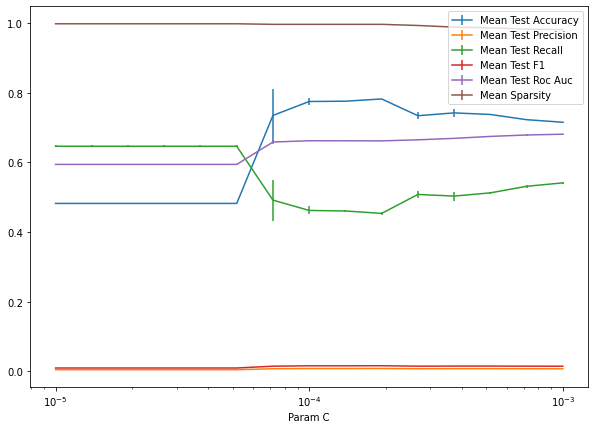

In [82]:
big_func(VIRAL_THR = 100, l1_log_min = -5, l1_log_max = -3)

In [ ]:
big_func(VIRAL_THR = 5)

In [ ]:
clf = LinearSVC(dual = False, max_iter = 10000, penalty = 'l1', C = 0.01).fit(features_train[all_idx], viral_label_train[all_idx])

In [32]:
pred = clf.predict(features_test)

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

f1_score(viral_label_test, pred)

0.03330606282527229

<a id='training_regression'></a>
# 4. Regressing number of occurences

<a id='theory_reg'></a>
## 4.A. Theoretical explanations of the methods used to perform the regression
[Back to table of content](#table_of_contents)

In this section, we will describe the mathematical models/concepts of the machine learning methods we will use in order to regress the occurrence of a quote from some features previously selected. 

We will focus on a simple regression method: linear regression.

<a id='lin_reg_theory'></a>
### 4.A.a. Linear Regression

Regression problems are problems aiming at finding a function $f$ that estimates the relationship between categorical or continuous inputs and an output continuous variable.

Linear regression is a specific modelling technique to resolve regression problems. Specifically, it is a model in which we assume that the output variable can be predicted from a linear combination of the input variables such that: 

$$Y = f(X) = \alpha_0 + x_1\alpha_1 ... + x_n\alpha_n$$

Training of the model aims to find the coefficients $\alpha_i$. To find these, we typically minimize the mean squared error (MSE) defined as follows:

$$L_{MSE}(\alpha; x_i, y_i) = (y_i - f(\alpha; x_i))^2$$

We will also try to add $L2$ or $L1$ regularization terms to push the less meaningful terms towards 0 which will improve the interpretability of the results. In case of the linear regression with no regularization or with $L2$ regularization the solution has a closed-form. For $L1$ regularization there is no closed-form solution. When a closed-form solution is not available, linear regression can be solved via gradient descent. Even if a closed-form solution is available, it should be noted that it may require large amounts of memory to be computed for large training sets.

We want to start with linear regression for multiple reasons. The first one is that it is a simple, easy-to-train model which will allow us to handle bigger subsets of the dataset for training in a reasonable time. It's also interesting to see if linear relationships are enough to achieve rather good accuracy for such a complex dataset and it will constitute a good indicator as to whether low bias can be achieved with such a low complexity model.

For this model to be acceptable, there are some assumptions:
- The relationship between $X$ and $Y$ (features and quote count popularity) are linearly related. This might not be the case but we want to see if it is by gauging the accuracy of the model.

- The observations are independent of each other. Of course, this can never truly be the case in such a huge dataset influenced by extremely popular extremely quoted individuals, real-world events, and a ton of other params but we still think that we can apply this model with some amount of success.

In [6]:
from sklearn.linear_model import Lasso

In [7]:
def do_train_test_split(VIRAL_THR):
    # Load inside function to actually save RAM when deleting them.
    features, num_occurrences, features_cols_titles = make_features_labels_arrays(preprocessed_dataset_file_path = PREPROCESSED_DATASET_FILE_PATH)
    mask=features[:,features_cols_titles.index('quotation_topic_UNKNOWN')]==1
    mask=np.invert(mask.toarray())
    features=features[mask.nonzero()[0],:]
    num_occurrences=num_occurrences[mask.nonzero()[0]]
    
    
    # Train-Test stratified split with test ratio of 0.3
    viral_label = np.int32(num_occurrences > VIRAL_THR)

    print(f"Viral Thr: {VIRAL_THR}, {viral_label.mean():.3%} quotes are viral")    

    splits = train_test_split(features, num_occurrences, viral_label,
                              test_size = 0.995,
                              shuffle = True,
                              stratify = viral_label)

    return splits        

def sweep_l1_regularization(features, num_occurrences, cv_n_splits = 10,
                            n_jobs = 4, l1_log_min = -5, l1_log_max = 2, l1_log_steps = 50):
    
    print(f"Training on {len(num_occurrences)} samples with {features.shape[1]} features")
            
    res = GridSearchCV(estimator  = Lasso(max_iter = 10000, selection = 'random',tol=1e-1), 
                       param_grid = {'alpha': np.logspace(l1_log_min, l1_log_max, l1_log_steps)},
                       cv         = cv_n_splits,
                       scoring    = {'r2': 'r2',
                                     'max_error': 'max_error',
                                     'explained_variance': 'explained_variance',
                                     'sparsity' : lambda estimator, X, y: np.mean(np.abs(estimator.coef_) < 1e-8)},
                       return_train_score = True,
                       refit = False,
                       n_jobs = n_jobs,
                       verbose = 2).fit(features, num_occurrences)
    
    df = pd.DataFrame(res.cv_results_)
    df = df[[col for col in df.columns if col.startswith('param_') or re.match(r'^(mean|std)_(train|test)_', col)]]

    # Changing names of sparsity columns and dropping duplicates.
    df = df.drop(columns = ['mean_test_sparsity', 'std_test_sparsity']).rename(columns = {'mean_train_sparsity': 'mean_sparsity',
                                                                                          'std_train_sparsity' : 'std_sparsity'})

    return df


def plot_columns_over_column(df, x_axis_column, y_axis_columns, x_log_scale = True, figsize = (10, 7)):    
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    
    if x_log_scale:
        ax.set(xscale = 'log')
    
    for y in y_axis_columns:        
        ax.errorbar(df[x_axis_column], df[y], df[y.replace('mean', 'std')], label = y.replace('_', ' ').title())
        
    plt.xlabel(x_axis_column.replace('_', ' ').title())
    plt.legend()
    plt.show()

In [21]:
def big_func(VIRAL_THR, l1_log_min = -5, l1_log_max = 0):
    # Seed numpy for reproducibility of all following code.
    np.random.seed(0xADA)
    
    features_train, features_test, num_occurrences_train, num_occurrences_test, viral_label_train, viral_label_test = do_train_test_split(VIRAL_THR)

    df = sweep_l1_regularization(features_train, num_occurrences_train, 
                                 cv_n_splits = 10, # Can be reduced down to a minimum of 5 if needed
                                 n_jobs = 1, # This one depends on your CPU and RAM. Higher is faster, but only if you don't fill
                                              # your RAM and your CPU is not at 100% all cores. 
                                              # Start with one, using a fixed downsampling factor and increase it until RAM is filled,
                                              # up to a maximum the number of physical cores on your machine.
                                              # /!\ THE COMBINATION OF HIGH N_JOBS AND LOW DOWNSAMPLING FACTOR CAN CRASH YOUR SYSTEM!
                                              # (TECHNICALLY ONLY MAKE IT EXTREMELY UNRESPONSIVE, STILL NOT NICE)
                                 l1_log_min = l1_log_min, l1_log_max = l1_log_max, l1_log_steps = 15)
                                              # Min max and number os steps of sweep logspace.
                                              # Min and max probably do not need to be changed.
                                              # steps may be changed. Lower makes run faster,
                                              # but also decreases resolution of plots.
                                              # Warning: due to how regularized SVM 
                                              # works, large values of C parameter may
                                              # lead to very slow convergence (I can provide
                                              # intuitive explaination if needed). So for time
                                              # reasons it may be intersting to decrease l1_log_max,
                                              # FOR AS LONG AS A CONVERGENCE TO A MAX VAL F1 SCORE
                                              # CAN STILL BE OBSERVED IN THE PLOTS!!!
                                 
    
    # You can see how far in the cv you are in the jupyter console (the black terminal that is opened when you lanch jupyter).
    # For some reason, the logs from sklearn CV are written there when n_jobs > 1.
    # You can ignore all the UndefinedMetricWarning, unfortunately I was not able to tell sklearn not to show them.
    
    
    pd.options.display.max_rows = 1000
    display(df)
    
    #plot_columns_over_column(df, 'param_alpha', [col for col in df.columns if col.startswith('mean_test_')] + ['mean_sparsity'])

In [ ]:
big_func(VIRAL_THR = 100, l1_log_min = -5, l1_log_max = 2)

Viral Thr: 100, 0.405% quotes are viral
Training on 149857 samples with 627 features
Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] END ........................................alpha=1e-05; total time= 6.0min


In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression

In [76]:
def do_train_test_split(VIRAL_THR):
    # Load inside function to actually save RAM when deleting them.
    features, num_occurrences, features_cols_titles = make_features_labels_arrays(preprocessed_dataset_file_path = PREPROCESSED_DATASET_FILE_PATH)
    mask=features[:,features_cols_titles.index('quotation_topic_UNKNOWN')]==1
    mask=np.invert(mask.toarray())
    features=features[mask.nonzero()[0],:]
    num_occurrences=num_occurrences[mask.nonzero()[0]]
    
    
    # Train-Test stratified split with test ratio of 0.3
    viral_label = np.int32(num_occurrences > VIRAL_THR)

    print(f"Viral Thr: {VIRAL_THR}, {viral_label.mean():.3%} quotes are viral")    

    splits = train_test_split(features, num_occurrences, viral_label,
                              test_size = 0.999,
                              shuffle = True,
                              stratify = viral_label)

    return splits        

def sweep_l1_regularization(features, num_occurrences, cv_n_splits = 10,
                            n_jobs = 4, l1_log_min = -5, l1_log_max = 2, l1_log_steps = 50):
    
    print(f"Training on {len(num_occurrences)} samples with {features.shape[1]} features")
    kbest = SelectKBest()
    
    pipe = make_pipeline(kbest, LinearRegression())
    
    grid = GridSearchCV(estimator  =pipe, 
                        param_grid = {'selectkbest__score_func': [f_regression],
                                           'selectkbest__k': [10,50,100,200,600]},
                        scoring    ={'r2':'r2'},
                        cv         = cv_n_splits,
                        return_train_score = True,
                        refit = False,
                        n_jobs = n_jobs,
                        verbose = 2).fit(features, num_occurrences)
            
    df = pd.DataFrame(grid.cv_results_)
    
    return df
   



def plot_columns_over_column(df, x_axis_column, y_axis_columns, x_log_scale = True, figsize = (10, 7)):    
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    
    if x_log_scale:
        ax.set(xscale = 'log')
    
    for y in y_axis_columns:        
        ax.errorbar(df[x_axis_column], df[y], df[y.replace('mean', 'std')], label = y.replace('_', ' ').title())
        
    plt.xlabel(x_axis_column.replace('_', ' ').title())
    plt.legend()
    plt.show()

In [77]:
big_func(VIRAL_THR = 100, l1_log_min = -5, l1_log_max = 2)


Viral Thr: 100, 0.405% quotes are viral
Training on 29971 samples with 627 features
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] END selectkbest__k=10, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s
[CV] END selectkbest__k=10, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s
[CV] END selectkbest__k=10, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s
[CV] END selectkbest__k=10, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s
[CV] END selectkbest__k=10, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coeffici

[CV] END selectkbest__k=10, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s
[CV] END selectkbest__k=10, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s
[CV] END selectkbest__k=10, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s
[CV] END selectkbest__k=10, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s
[CV] END selectkbest__k=10, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coeffici

[CV] END selectkbest__k=50, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s
[CV] END selectkbest__k=50, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=50, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s
[CV] END selectkbest__k=50, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=50, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s
[CV] END selectkbest__k=50, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=50, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s
[CV] END selectkbest__k=50, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=50, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s
[CV] END selectkbest__k=50, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.0s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=100, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.1s
[CV] END selectkbest__k=100, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.1s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=100, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.1s
[CV] END selectkbest__k=100, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.1s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=100, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.1s
[CV] END selectkbest__k=100, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.1s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=100, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.1s
[CV] END selectkbest__k=100, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.1s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=100, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.1s
[CV] END selectkbest__k=100, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.1s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=200, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.1s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=200, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.1s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=200, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.3s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=200, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.4s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=200, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.3s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=200, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.1s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=200, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.1s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=200, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.3s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=200, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.4s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=200, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.3s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=600, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.3s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=600, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.4s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=600, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.3s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=600, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.3s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=600, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.3s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=600, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.6s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=600, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.5s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=600, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.3s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=600, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.2s


C:\Users\Mattia\Anaconda3\envs\ada\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[CV] END selectkbest__k=600, selectkbest__score_func=<function f_regression at 0x0000020F9D8D1820>; total time=   0.2s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selectkbest__k,param_selectkbest__score_func,params,split0_test_r2,split1_test_r2,split2_test_r2,...,split2_train_r2,split3_train_r2,split4_train_r2,split5_train_r2,split6_train_r2,split7_train_r2,split8_train_r2,split9_train_r2,mean_train_r2,std_train_r2
0,0.029404,0.006860,0.001599,0.000660,10,<function f_regression at 0x0000020F9D8D1820>,"{'selectkbest__k': 10, 'selectkbest__score_fun...",-0.053901,-0.008282,-0.005260,...,0.029697,0.031213,0.031353,0.022774,0.026482,0.026039,0.025603,0.031893,0.028158,0.002821
1,0.102699,0.006403,0.001000,0.000447,50,<function f_regression at 0x0000020F9D8D1820>,"{'selectkbest__k': 50, 'selectkbest__score_fun...",-0.085229,-0.025162,-0.005752,...,0.043300,0.046441,0.045794,0.036819,0.041435,0.043051,0.038862,0.047384,0.043277,0.003268
2,0.176988,0.012651,0.001300,0.000458,100,<function f_regression at 0x0000020F9D8D1820>,"{'selectkbest__k': 100, 'selectkbest__score_fu...",-0.089271,-0.030518,-0.005927,...,0.046787,0.050073,0.049404,0.040431,0.044702,0.047026,0.042539,0.050794,0.046877,0.003230
3,0.334808,0.100769,0.001999,0.000632,200,<function f_regression at 0x0000020F9D8D1820>,"{'selectkbest__k': 200, 'selectkbest__score_fu...",-0.085910,-0.032624,-0.007165,...,0.048892,0.052180,0.051490,0.042575,0.046793,0.048825,0.044368,0.052762,0.048885,0.003223
4,0.440582,0.102444,0.001200,0.000401,600,<function f_regression at 0x0000020F9D8D1820>,"{'selectkbest__k': 600, 'selectkbest__score_fu...",-0.090246,-0.039108,-0.010065,...,0.051026,0.054222,0.053384,0.044609,0.048746,0.050750,0.046458,0.054658,0.050888,0.003194


In [51]:
pipe = make_pipeline(SelectKBest(), LinearRegression())
print(pipe.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'selectkbest', 'linearregression', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])


SyntaxError: invalid syntax (Temp/ipykernel_24072/3250342156.py, line 1)

In [21]:
from scipy.stats import ks_2samp


def do_train_test_split(VIRAL_THR):
    # Load inside function to actually save RAM when deleting them.
    features, num_occurrences, features_cols_titles = make_features_labels_arrays(preprocessed_dataset_file_path = PREPROCESSED_DATASET_FILE_PATH)

    # Train-Test stratified split with test ratio of 0.3
    viral_label = np.int32(num_occurrences > VIRAL_THR)

    print(f"Viral Thr: {VIRAL_THR}, {viral_label.mean():.3%} quotes are viral")    

    splits = train_test_split(features, num_occurrences, viral_label,
                              test_size = 0.3,
                              shuffle = True,
                              stratify = viral_label)

    return splits, features_cols_titles       


def big_func(VIRAL_THR):
    # Seed numpy for reproducibility of all following code.
    np.random.seed(0xADA)
    
    (features_train, features_test, num_occurrences_train, num_occurrences_test, _, _), features_cols_titles = do_train_test_split(VIRAL_THR)

    pvalues_dict = {}
    for feature_idx, feature_name in enumerate(features_cols_titles):
        print(f"Doing feature {feature_idx + 1} of {len(features_cols_titles)}")
        feature_col = features_train[:, feature_idx].toarray().ravel()
        
        unique_vals = np.unique(feature_col)
        if not (len(unique_vals) == 2 and unique_vals.min() == 0 and unique_vals.max() == 1):
            continue

        positive_num_occurrences_train = num_occurrences_train[feature_col == 1]
        negative_num_occurrences_train = num_occurrences_train[feature_col == 0]
        
        if len(positive_num_occurrences_train) == 0 or len(negative_num_occurrences_train) == 0:
            pvalue = 1
        else:
            _, pvalue = ks_2samp(positive_num_occurrences_train, negative_num_occurrences_train, mode = 'auto')
        
        pvalues_dict[feature_name] = pvalue
    
    return pvalues_dict

pvalues_dict = big_func(100)

Viral Thr: 100, 0.399% quotes are viral
Doing feature 0 of 613
Doing feature 1 of 613
Doing feature 2 of 613
Doing feature 3 of 613
Doing feature 4 of 613
Doing feature 5 of 613
Doing feature 6 of 613
Doing feature 7 of 613
Doing feature 8 of 613
Doing feature 9 of 613
Doing feature 10 of 613
Doing feature 11 of 613
Doing feature 12 of 613
Doing feature 13 of 613
Doing feature 14 of 613
Doing feature 15 of 613
Doing feature 16 of 613
Doing feature 17 of 613
Doing feature 18 of 613
Doing feature 19 of 613
Doing feature 20 of 613
Doing feature 21 of 613
Doing feature 22 of 613
Doing feature 23 of 613
Doing feature 24 of 613
Doing feature 25 of 613
Doing feature 26 of 613
Doing feature 27 of 613
Doing feature 28 of 613
Doing feature 29 of 613
Doing feature 30 of 613
Doing feature 31 of 613
Doing feature 32 of 613
Doing feature 33 of 613
Doing feature 34 of 613
Doing feature 35 of 613
Doing feature 36 of 613
Doing feature 37 of 613
Doing feature 38 of 613
Doing feature 39 of 613
Doing feat

Doing feature 331 of 613
Doing feature 332 of 613
Doing feature 333 of 613
Doing feature 334 of 613
Doing feature 335 of 613
Doing feature 336 of 613
Doing feature 337 of 613
Doing feature 338 of 613
Doing feature 339 of 613
Doing feature 340 of 613
Doing feature 341 of 613
Doing feature 342 of 613
Doing feature 343 of 613
Doing feature 344 of 613
Doing feature 345 of 613
Doing feature 346 of 613
Doing feature 347 of 613
Doing feature 348 of 613
Doing feature 349 of 613
Doing feature 350 of 613
Doing feature 351 of 613
Doing feature 352 of 613
Doing feature 353 of 613
Doing feature 354 of 613
Doing feature 355 of 613
Doing feature 356 of 613
Doing feature 357 of 613
Doing feature 358 of 613
Doing feature 359 of 613
Doing feature 360 of 613
Doing feature 361 of 613
Doing feature 362 of 613
Doing feature 363 of 613
Doing feature 364 of 613
Doing feature 365 of 613
Doing feature 366 of 613
Doing feature 367 of 613
Doing feature 368 of 613
Doing feature 369 of 613
Doing feature 370 of 613


In [43]:
df = pd.DataFrame(pvalues_dict.items(), columns = ['feature_title', 'pvalue'])
df = df.sort_values('pvalue').reset_index(drop = True)
pd.options.display.max_rows = 1000
df

,feature_title,pvalue
0,speaker_occupation_TELEVISION PRESENTER,0.000000e+00
1,quotation_topic_4_CRICKET_PITCHES_WICKETS_INNINGS,0.000000e+00
2,speaker_occupation_SINGER,0.000000e+00
3,speaker_occupation_WRITER,0.000000e+00
4,quotation_topic_100_COMMUNITY_COMMUNITIES_SUPP...,0.000000e+00
5,quotation_topic_1_STUDENTS_EDUCATION_SCHOOLS_T...,0.000000e+00
6,quotation_topic_59_RUSSIA_RUSSIAN_PUTIN_UKRAINE,0.000000e+00
7,quotation_topic_29_CHINA_CHINESE_TAIWAN_BEIJING,0.000000e+00
8,speaker_occupation_RESTAURATEUR,0.000000e+00
9,quotation_topic_24_VOLUNTEERS_FUNDING_CHARITY_...,0.000000e+00


In [44]:
# Extract features for which distribution when value is 0 and when it is 1 is statistically signifantly different.

five_sigma_pvalue = 3e-7

significance_adjusted_per_comparison = 1 - (1 - five_sigma_pvalue)**(1 / len(df))

df[df['pvalue'] < significance_adjusted_per_comparison]

,feature_title,pvalue
0,speaker_occupation_TELEVISION PRESENTER,0.000000e+00
1,quotation_topic_4_CRICKET_PITCHES_WICKETS_INNINGS,0.000000e+00
2,speaker_occupation_SINGER,0.000000e+00
3,speaker_occupation_WRITER,0.000000e+00
4,quotation_topic_100_COMMUNITY_COMMUNITIES_SUPP...,0.000000e+00
5,quotation_topic_1_STUDENTS_EDUCATION_SCHOOLS_T...,0.000000e+00
6,quotation_topic_59_RUSSIA_RUSSIAN_PUTIN_UKRAINE,0.000000e+00
7,quotation_topic_29_CHINA_CHINESE_TAIWAN_BEIJING,0.000000e+00
8,speaker_occupation_RESTAURATEUR,0.000000e+00
9,quotation_topic_24_VOLUNTEERS_FUNDING_CHARITY_...,0.000000e+00


In [8]:
def do_train_test_split(VIRAL_THR):
    # Load inside function to actually save RAM when deleting them.
    features, num_occurrences, features_cols_titles = make_features_labels_arrays(preprocessed_dataset_file_path = PREPROCESSED_DATASET_FILE_PATH)

    # Train-Test stratified split with test ratio of 0.3
    viral_label = np.int32(num_occurrences > VIRAL_THR)

    print(f"Viral Thr: {VIRAL_THR}, {viral_label.mean():.3%} quotes are viral")    

    splits = train_test_split(features, num_occurrences, viral_label,
                              test_size = 0.3,
                              shuffle = True,
                              stratify = viral_label)

    return splits, features_cols_titles       


def big_func(VIRAL_THR):
    # Seed numpy for reproducibility of all following code.
    np.random.seed(0xADA)
    
    (features_train, features_test, num_occurrences_train, num_occurrences_test, _, _), features_cols_titles = do_train_test_split(VIRAL_THR)

    return scipy.sparse.linalg.lsqr(features_train, num_occurrences_train, show = True)
    

res = big_func(100)

Viral Thr: 100, 0.399% quotes are viral
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 48345280 rows and 613 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =     1226
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   5.455e+05  5.455e+05    1.0e+00  1.3e-02
     1  8.47659e-02   5.451e+05  5.451e+05    1.0e+00  8.8e-04   2.2e+05  1.0e+00
     2 -1.62997e-02   5.448e+05  5.448e+05    1.0e+00  2.3e-04   2.2e+05  4.2e+01
     3 -2.64953e-02   5.447e+05  5.447e+05    1.0e+00  9.5e-05   2.2e+05  8.8e+01
     4 -2.09079e-02   5.447e+05  5.447e+05    1.0e+00  2.6e-03   2.2e+05  9.4e+01
     5 -3.65728e-02   5.447e+05  5.447e+05    1.0e+00  3.2e-05   3.1e+05  1.9e+02
     6 -3.78333e-02   5.447e+05  5.447e+05    1.0e+00  2.2e-05   3.1e+05  2.4e+02
     7 -3.67427e-02   5.447e+05  5.447e+05    1.0e+00  3.1e-05   3.1e+05 